In [1]:
import numpy as np
from numpy.random import uniform
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm

In [2]:
def sinusoid(x, x0 = 0, A = 1, B = 1, C = 0, D = 0):
    """A sine wave.

    Args:
        x (float): argument
        x0 (float): initial value
        A (float): amplitude
        B (float): frequency
        C (float): horizontal shift
        D (float): vertical shift

    Returns:
        float: value of the function
    """
    y = A*np.sin(x0 + B*(x - C)) + D
    return y


def get_sample(x_dim, random = True):
    params = {}
    if random:
        params['x0'] = uniform(low = 0, high = 1)
        params['A'] = uniform(low = 0.5, high = 0.8)
        params['B'] = uniform(low = 1.2, high = 1.5)
    sample = np.array([
        sinusoid(x = item, **params)
        for item in range(x_dim)
    ])
    return sample

In [3]:
samples = np.stack([get_sample(20) for i in range(5000)])

In [4]:
learningRate = 0.002
featureCount = samples.shape[1]
epochCount = 1
dim_z = 2
dimHidden_D = samples.shape[1]
dimHidden_G = samples.shape[1]

In [5]:
biasOnOff = True

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()  #delegates the function call to the parent class 'nn.Module'
        self.main = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = featureCount, out_features = dimHidden_D, bias = biasOnOff),
            nn.LeakyReLU(),

            # 2nd layer
            nn.Linear(in_features = dimHidden_D, out_features = dimHidden_D, bias = biasOnOff),
            nn.LeakyReLU(),

            # 3rd layer
            nn.Linear(in_features = dimHidden_D, out_features = 1, bias = biasOnOff),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

##################################################

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 1st layer
            nn.Linear(in_features = dim_z, out_features = dimHidden_G, bias = biasOnOff),
            nn.ReLU(inplace = True),

            # 2nd layer
            nn.Linear(in_features = dimHidden_G, out_features = dimHidden_G, bias = biasOnOff),
            nn.ReLU(inplace = True),

            # 3rd layer
            nn.Linear(in_features = dimHidden_G, out_features = featureCount, bias = biasOnOff),
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

##################################################

def initialize_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_uniform_(model.weight)
        model.bias.data.fill_(0.001)

In [7]:
#device = torch.device('cuda:0')
device = torch.device('cpu')

tensor = torch.Tensor(samples)
dataset = TensorDataset(tensor)
dataloader = DataLoader(dataset)

model_G = Generator().to(device)
model_G.apply(initialize_weights)

model_D = Discriminator().to(device)
model_D.apply(initialize_weights)

# Loss function: Binary Cross-Entropy
criterion = nn.BCELoss()

# Optimizers: Adam
optimizer_D = optim.Adam(params = model_D.parameters(), lr = learningRate)
optimizer_G = optim.Adam(params = model_G.parameters(), lr = learningRate)

In [8]:
for epoch in range(epochCount):
    print(f'Epoch [{epoch + 1}/{epochCount}]')
    for idx, data in enumerate(tqdm(dataloader)):
        x_real = data[0].to(device)
        label_real = torch.full((x_real.size(0), 1), 1, dtype = torch.float, device = device)   #created in real time since the last batch might be smaller than the others
        label_fake = torch.full((x_real.size(0), 1), 0, dtype = torch.float, device = device)

        # Update D with real data
        model_D.zero_grad()
        y_real = model_D(x_real)
        loss_D_real = criterion(y_real, label_real)
        loss_D_real.backward()

        # Updata D with fake data
        z = torch.randn(size = (x_real.size(0), dim_z), device = device)
        x_fake = model_G(z)
        y_fake = model_D(x_fake.detach())
        loss_D_fake = criterion(y_fake, label_fake)
        loss_D_fake.backward()
        optimizer_D.step()

        # Update G with fake data
        model_G.zero_grad()
        y_fake_r = model_D(x_fake)
        loss_G = criterion(y_fake_r, label_real)
        loss_G.backward()
        optimizer_G.step()

        if idx % 1000 == 0:
            print(f'loss_D: {loss_D_real.mean().item()}\nloss_D_fake: {loss_D_fake.mean().item()}\nloss_G: {loss_G.mean().item()}\n')

Epoch [1/1]


  0%|          | 0/5000 [00:00<?, ?it/s]

loss_D: 0.7985400557518005
loss_D_fake: 0.3811299204826355
loss_G: 1.2311811447143555

loss_D: 0.2904892563819885
loss_D_fake: 0.45166298747062683
loss_G: 1.062587857246399

loss_D: 0.9111728668212891
loss_D_fake: 0.31201744079589844
loss_G: 1.31540846824646

loss_D: 0.25269630551338196
loss_D_fake: 0.5736953616142273
loss_G: 0.887592077255249

loss_D: 0.31195953488349915
loss_D_fake: 0.5937110185623169
loss_G: 0.8650668263435364



#### Fake

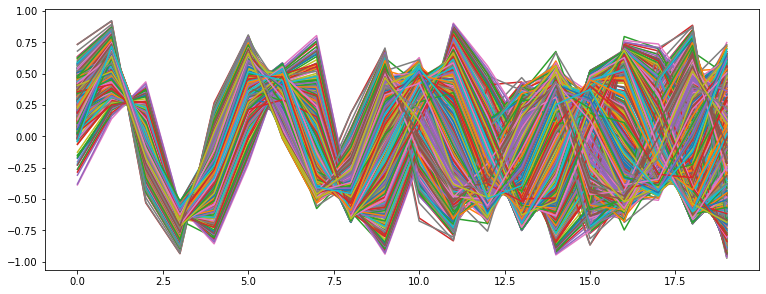

In [9]:
samples_fake = []

for count in range(1000):
    z_ = torch.randn(size = (x_real.size(0), dim_z), device = device)
    x_fake_ = model_G(z_).detach().numpy().reshape(-1)
    samples_fake.append(x_fake_)
samples_fake = np.stack(samples_fake)

plt.figure(figsize = (12.8, 4.8))
plt.plot(samples_fake.T);

#### Real

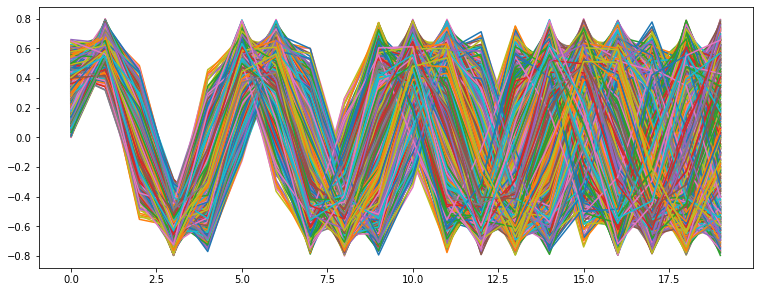

In [10]:
plt.figure(figsize = (12.8, 4.8))
plt.plot(samples[:1000, :].T);